In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
import matplotlib.patches as patches

In [2]:
def create_test_cases():
    """Create synthetic test cases for ROM/RUM validation"""
    test_cases = []
    
    # Test Case 1: Perfect segmentation (ROM=0, RUM=0)
    gt1 = np.zeros((10, 10), dtype=int)
    gt1[2:8, 2:8] = 1  # One square region
    pred1 = gt1.copy()  # Perfect match
    test_cases.append(("Perfect segmentation", gt1, pred1, 0.0, 0.0))
    
    # Test Case 2: Simple over-segmentation (ROM should be high)
    gt2 = np.zeros((10, 10), dtype=int)
    gt2[2:8, 2:8] = 1  # One square region
    pred2 = np.zeros((10, 10), dtype=int)
    pred2[2:5, 2:8] = 1  # Top half
    pred2[5:8, 2:8] = 1  # Bottom half (split into 2)
    test_cases.append(("Over-segmentation (1→2)", gt2, pred2, "high", 0.0))
    
    # Test Case 3: More severe over-segmentation
    gt3 = np.zeros((10, 10), dtype=int)
    gt3[2:8, 2:8] = 1  # One square region
    pred3 = np.zeros((10, 10), dtype=int)
    pred3[2:4, 2:4] = 1  # Split into 4 quarters
    pred3[2:4, 6:8] = 1
    pred3[6:8, 2:4] = 1
    pred3[6:8, 6:8] = 1
    test_cases.append(("Over-segmentation (1→4)", gt3, pred3, "very high", 0.0))
    
    # Test Case 4: Simple under-segmentation (RUM should be high)
    gt4 = np.zeros((10, 10), dtype=int)
    gt4[2:4, 2:4] = 1  # Four separate small regions
    gt4[2:4, 6:8] = 1
    gt4[6:8, 2:4] = 1
    gt4[6:8, 6:8] = 1
    pred4 = np.zeros((10, 10), dtype=int)
    pred4[2:8, 2:8] = 1  # Merged into one
    test_cases.append(("Under-segmentation (4→1)", gt4, pred4, 0.0, "high"))
    
    # Test Case 5: Two regions under-segmented
    gt5 = np.zeros((10, 10), dtype=int)
    gt5[1:4, 1:4] = 1  # Two separate regions
    gt5[6:9, 6:9] = 1
    pred5 = np.zeros((10, 10), dtype=int)
    pred5[1:9, 1:9] = 1  # Merged into one large region
    test_cases.append(("Under-segmentation (2→1)", gt5, pred5, 0.0, "moderate"))
    
    # Test Case 6: Mixed (both over and under)
    gt6 = np.zeros((10, 10), dtype=int)
    gt6[1:5, 1:4] = 1  # Left region
    gt6[1:5, 6:9] = 1  # Right region
    pred6 = np.zeros((10, 10), dtype=int)
    pred6[1:3, 1:9] = 1  # Top merged (under-segmentation)
    pred6[3:5, 1:4] = 1  # Bottom left
    pred6[3:5, 6:9] = 1  # Bottom right
    test_cases.append(("Mixed over/under", gt6, pred6, "moderate", "moderate"))
    
    return test_cases

def visualize_test_case(name, gt, pred, expected_rom, expected_rum, actual_rom, actual_rum):
    """Visualize a test case with ground truth, prediction, and metrics"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    
    # Ground truth
    ax1.imshow(gt, cmap='tab20', vmin=0, vmax=1)
    ax1.set_title('Ground Truth')
    ax1.axis('off')
    
    # Add region boundaries
    gt_labeled = label(gt)
    for region_id in np.unique(gt_labeled)[1:]:  # Skip background
        mask = gt_labeled == region_id
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0:
            rect = patches.Rectangle((x_indices.min()-0.5, y_indices.min()-0.5),
                                   x_indices.max()-x_indices.min()+1,
                                   y_indices.max()-y_indices.min()+1,
                                   linewidth=2, edgecolor='red', facecolor='none')
            ax1.add_patch(rect)
    
    # Prediction
    ax2.imshow(pred, cmap='tab20', vmin=0, vmax=1)
    ax2.set_title('Prediction')
    ax2.axis('off')
    
    # Add region boundaries
    pred_labeled = label(pred)
    for region_id in np.unique(pred_labeled)[1:]:  # Skip background
        mask = pred_labeled == region_id
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0:
            rect = patches.Rectangle((x_indices.min()-0.5, y_indices.min()-0.5),
                                   x_indices.max()-x_indices.min()+1,
                                   y_indices.max()-y_indices.min()+1,
                                   linewidth=2, edgecolor='blue', facecolor='none')
            ax2.add_patch(rect)
    
    # Metrics
    ax3.text(0.1, 0.8, f"Test: {name}", fontsize=12, weight='bold')
    ax3.text(0.1, 0.6, f"Expected ROM: {expected_rom}", fontsize=10)
    ax3.text(0.1, 0.5, f"Actual ROM: {actual_rom:.3f}", fontsize=10, 
             color='green' if isinstance(expected_rom, float) and abs(actual_rom - expected_rom) < 0.01 else 'black')
    ax3.text(0.1, 0.3, f"Expected RUM: {expected_rum}", fontsize=10)
    ax3.text(0.1, 0.2, f"Actual RUM: {actual_rum:.3f}", fontsize=10,
             color='green' if isinstance(expected_rum, float) and abs(actual_rum - expected_rum) < 0.01 else 'black')
    ax3.axis('off')
    
    plt.suptitle(name)
    plt.tight_layout()
    return fig

def run_tests(ROM_func, RUM_func):
    """Run all test cases and visualize results"""
    test_cases = create_test_cases()
    
    print("Running ROM/RUM Test Cases")
    print("=" * 60)
    
    for name, gt, pred, expected_rom, expected_rum in test_cases:
        # Calculate actual ROM and RUM
        actual_rom = ROM_func(gt, pred)
        actual_rum = RUM_func(gt, pred)
        
        # Print results
        print(f"\n{name}:")
        print(f"  Expected ROM: {expected_rom}, Actual: {actual_rom:.3f}")
        print(f"  Expected RUM: {expected_rum}, Actual: {actual_rum:.3f}")
        
        # Count regions for debugging
        gt_regions = len(np.unique(label(gt))) - 1
        pred_regions = len(np.unique(label(pred))) - 1
        print(f"  GT regions: {gt_regions}, Pred regions: {pred_regions}")
        
        # Visualize
        fig = visualize_test_case(name, gt, pred, expected_rom, expected_rum, 
                                  actual_rom, actual_rum)
        plt.show()
    
    # Additional debugging: Show intermediate values for one case
    print("\n" + "="*60)
    print("Detailed analysis for over-segmentation case:")
    gt_debug = test_cases[1][1]  # Over-segmentation case
    pred_debug = test_cases[1][2]
    
    # Your original implementation's intermediate values
    debug_rom_calculation(gt_debug, pred_debug)

def debug_rom_calculation(gt, pred):
    """Show intermediate calculation steps for ROM"""
    gt_regions = label(gt)
    pred_regions = label(pred)
    
    num_gt_regions = len(np.unique(gt_regions)) - 1
    num_pred_regions = len(np.unique(pred_regions)) - 1
    
    print("\nDebug ROM calculation:")
    print(f"Number of GT regions: {num_gt_regions}")
    print(f"Number of Pred regions: {num_pred_regions}")
    
    # Show which regions overlap
    for i in range(1, num_gt_regions + 1):
        gt_region = gt_regions == i
        print(f"\nGT region {i}:")
        overlapping = []
        for j in range(1, num_pred_regions + 1):
            pred_region = pred_regions == j
            if np.sum(gt_region & pred_region) > 0:
                overlap_size = np.sum(gt_region & pred_region)
                overlapping.append((j, overlap_size))
        print(f"  Overlaps with pred regions: {overlapping}")

In [3]:
from metrics import ROM, RUM

Running ROM/RUM Test Cases

Perfect segmentation:
  Expected ROM: 0.0, Actual: 0.000
  Expected RUM: 0.0, Actual: 0.000
  GT regions: 1, Pred regions: 1


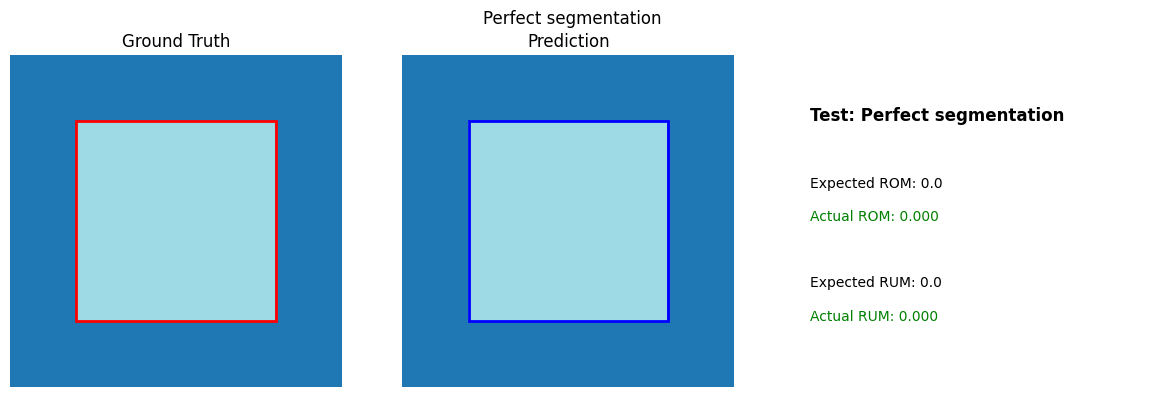


Over-segmentation (1→2):
  Expected ROM: high, Actual: 0.000
  Expected RUM: 0.0, Actual: 0.000
  GT regions: 1, Pred regions: 1


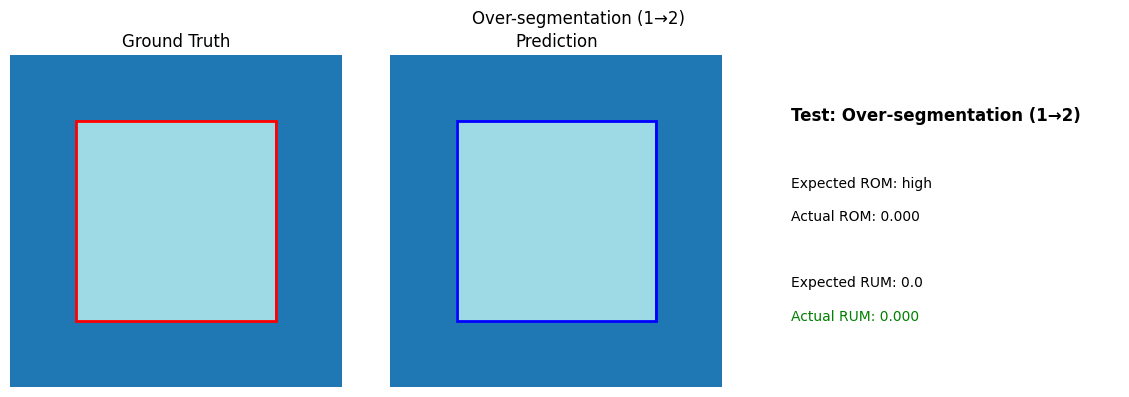


Over-segmentation (1→4):
  Expected ROM: very high, Actual: 0.995
  Expected RUM: 0.0, Actual: 0.000
  GT regions: 1, Pred regions: 4


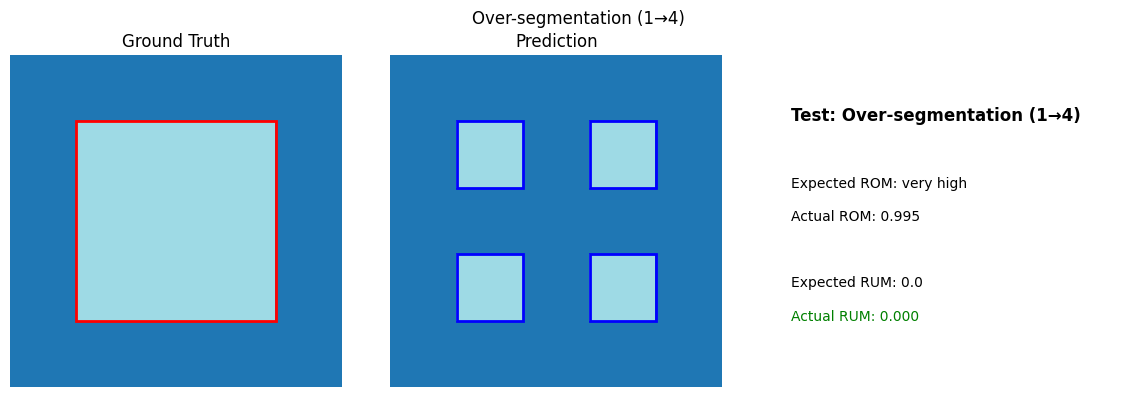


Under-segmentation (4→1):
  Expected ROM: 0.0, Actual: 0.000
  Expected RUM: high, Actual: 0.995
  GT regions: 4, Pred regions: 1


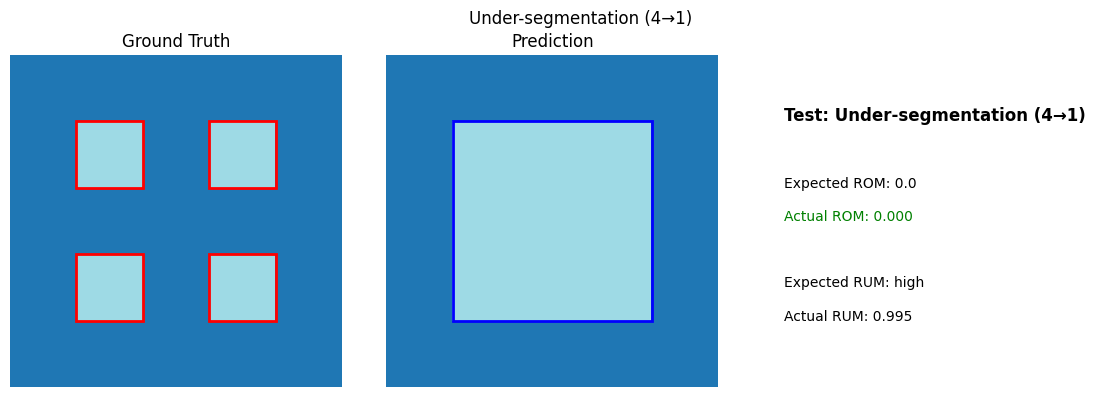


Under-segmentation (2→1):
  Expected ROM: 0.0, Actual: 0.000
  Expected RUM: moderate, Actual: 0.762
  GT regions: 2, Pred regions: 1


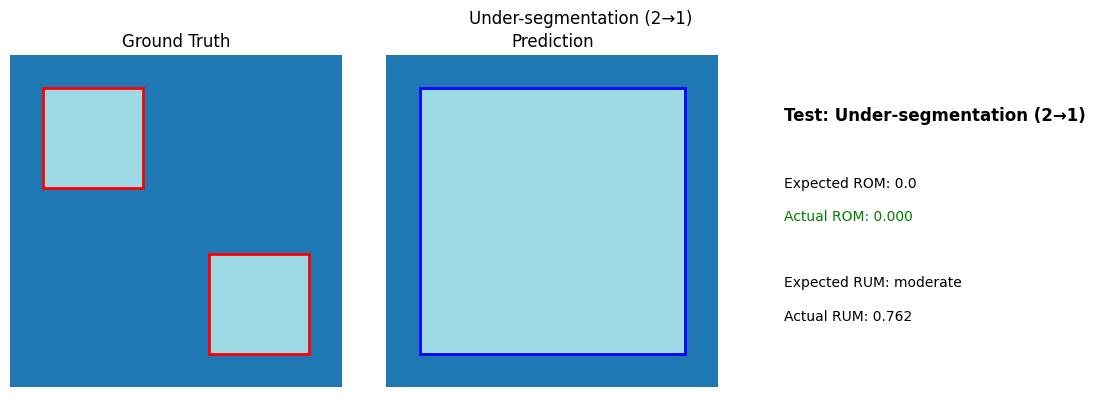


Mixed over/under:
  Expected ROM: moderate, Actual: 0.000
  Expected RUM: moderate, Actual: 0.762
  GT regions: 2, Pred regions: 1


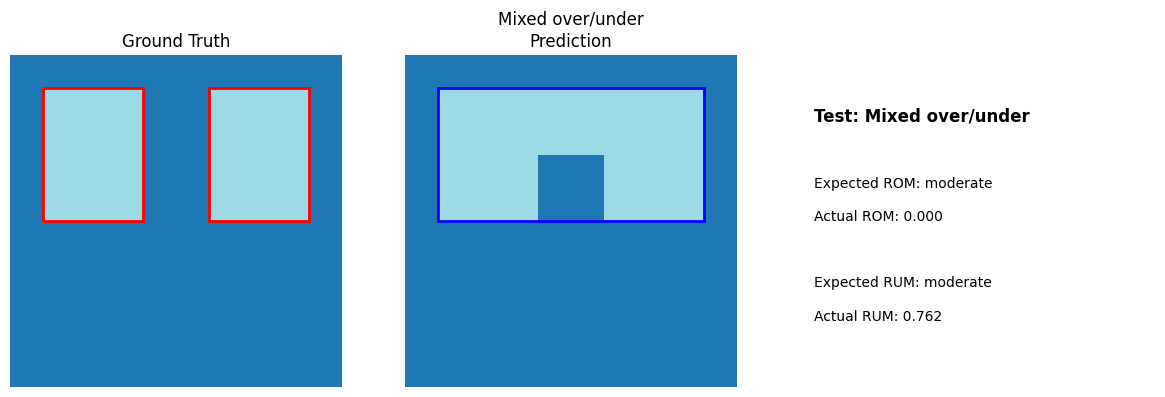


Detailed analysis for over-segmentation case:

Debug ROM calculation:
Number of GT regions: 1
Number of Pred regions: 1

GT region 1:
  Overlaps with pred regions: [(1, 36)]


In [4]:
run_tests(ROM, RUM)